In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_parquet("processed/final_dataset.parquet")

In [3]:
len(train)


23060846

In [4]:
def make_features(df):
    # === 1. Convert timestamp to datetime and remove timezone ===
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    
    # === 2. Hour-based features ===
    df["hour"] = df["timestamp"].dt.hour.astype('int8')
    df["minute"] = df["timestamp"].dt.minute.astype('int8')
    df["day_of_week"] = df["timestamp"].dt.dayofweek.astype('int8')
    df["elapsed_time_from_midnight"] = (df["hour"] * 60 + df["minute"]).astype('int32')
    df["is_weekend"] = (df["day_of_week"] >= 5).astype('int8')
    df["is_night"] = ((df["hour"] >= 22) | (df["hour"] <= 6)).astype('int8')

    # === 3. Time-based features ===
    periods = 20
    df["anglez"] = abs(df["anglez"])
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).bfill().astype('float16')
    df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).bfill().astype('float16')

    # === 4. Rolling statistical features (mean, max, std, etc.) ===
    window_sizes = [12, 100, 360]  # in 5-second steps
    for window in window_sizes:
        for col in ['anglez', 'enmo']:
            df[f'{col}_mean_{window}s'] = df[col].rolling(window, min_periods=1).mean().astype('float16')
            df[f'{col}_std_{window}s'] = df[col].rolling(window, min_periods=1).std().astype('float16')
            df[f'{col}_min_{window}s'] = df[col].rolling(window, min_periods=1).min().astype('float16')
            df[f'{col}_max_{window}s'] = df[col].rolling(window, min_periods=1).max().astype('float16')
            df[f'{col}_median_{window}s'] = df[col].rolling(window, min_periods=1).median().astype('float16')
            df[f'{col}_cumulative_{window}s'] = df[col].rolling(window, min_periods=1).sum().astype('float16')

    # === 5. Advanced Feature Engineering ===
    df["anglez_delta"] = (df["anglez"] - df["anglez"].shift(1)).astype('float16')

    # Simple Moving Average (SMA) for enmo
    sma_windows = [12, 100, 360]
    for window in sma_windows:
        df[f'enmo_sma_{window}s'] = df['enmo'].rolling(window, min_periods=1).mean().astype('float16')

    # === 6. Lag Features ===
    lag_targets = [
        "anglez", "enmo",
        "anglez_mean_12s", "anglez_std_12s",
        "enmo_mean_12s", "enmo_std_12s",
        "anglez_mean_100s", "anglez_std_100s",
        "enmo_mean_100s", "enmo_std_100s"
    ]
    lag_steps = [1, 2, 3]
    for col in lag_targets:
        for lag in lag_steps:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag).astype('float16')

    # === 7. Handle NaN values (filling missing values where appropriate) ===
    # Separate numeric columns for NaN filling
    # === 7. Handle NaN values (filling missing values where appropriate) ===
    # Fill only numeric columns, converting float16 to float32 for compatibility
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].astype('float32').bfill().ffill().astype(df[numeric_cols].dtypes.to_dict())

    return df

In [5]:
features = [
    "hour",
    "anglez",
    "anglez_mean_100s",
    "anglez_max_100s",
    "anglez_std_100s",
    "anglez_diff",
    "enmo",
    "enmo_mean_100s",
    "enmo_max_100s",
    "enmo_std_100s",
    "enmo_diff"
]

In [6]:
def showcor(X):

    plt.figure(figsize=(12, 10))
    sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Feature Correlation Heatmap (with values)")
    plt.show()

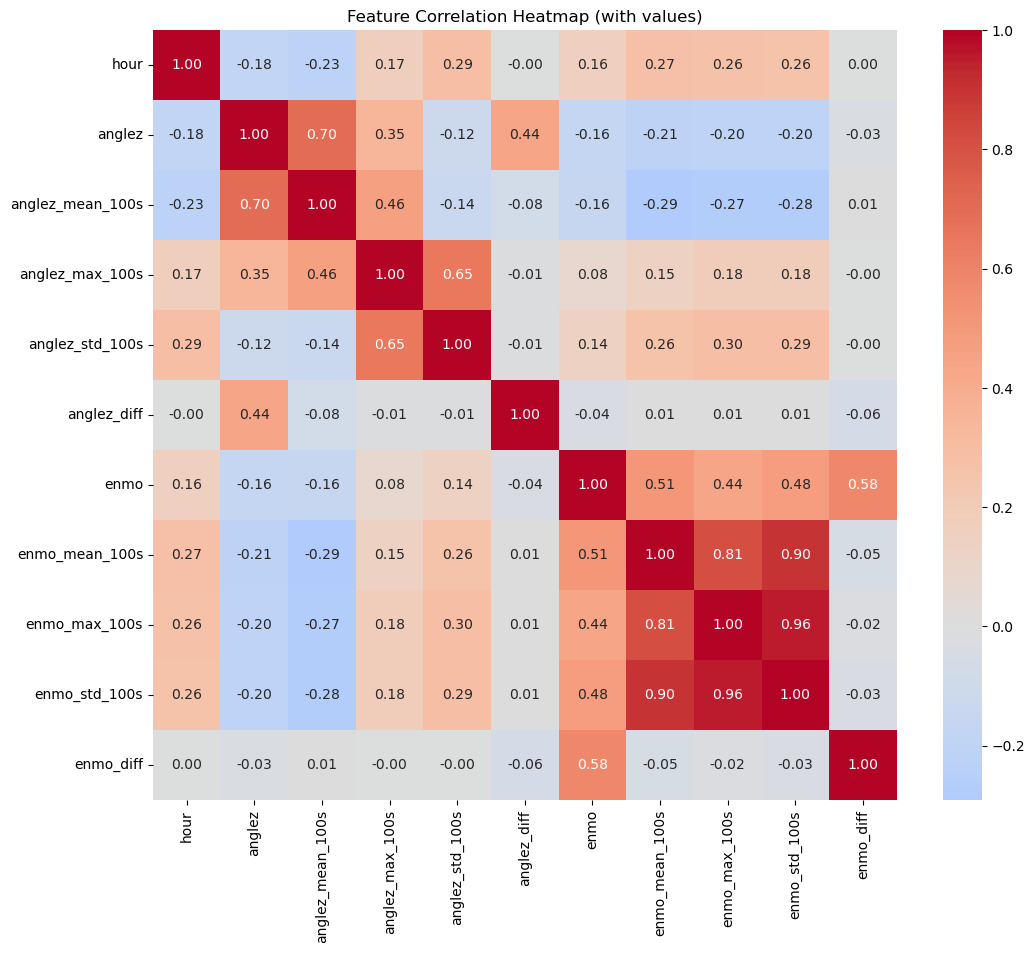

In [7]:
train = make_features(train)

X = train[features]
y = train["awake"]
groups = train["series_id"]

showcor(X)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import numpy as np
import pandas as pd

n_splits = 3
gkf = GroupKFold(n_splits=n_splits)

oof_preds = np.zeros(len(X))
oof_preds_not_awake = np.zeros(len(X))
feature_importances = np.zeros(X.shape[1])

# Optional: speichern der Metriken pro Fold
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    print(f"\n🔁 Fold {fold + 1}")

    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # Modell trainieren
    model = RandomForestClassifier(
        n_estimators=100,
        min_samples_leaf=300,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr, y_tr)

    # Vorhersagen
    probs = model.predict_proba(X_val)
    preds = model.predict(X_val)

    oof_preds[val_idx] = probs[:, 1]             # awake-Wahrscheinlichkeit
    oof_preds_not_awake[val_idx] = probs[:, 0]   # nicht-awake

    # Metriken
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    ap = average_precision_score(y_val, probs[:, 1])

    fold_metrics.append({
        'fold': fold + 1,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'average_precision': ap
    })

    print(f"📈 Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AP: {ap:.4f}")

    # Feature Importances aufsummieren
    feature_importances += model.feature_importances_

# Feature-Importance Mittelwert über Folds
avg_importances = feature_importances / n_splits
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': avg_importances
}).sort_values(by='importance', ascending=False)

# Metriken zusammenfassen
metrics_df = pd.DataFrame(fold_metrics)
print("\n📊 Fold-wise metrics:\n", metrics_df)
print(f"\n🔍 Mean Average Precision: {metrics_df['average_precision'].mean():.4f}")

print("\n🔥 Feature Importances:\n", importance_df)


🔁 Fold 1
📈 Precision: 0.9757 | Recall: 0.9688 | F1: 0.9722 | AP: 0.9954

🔁 Fold 2
📈 Precision: 0.9737 | Recall: 0.9521 | F1: 0.9628 | AP: 0.9929

🔁 Fold 3


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Nur einmalig am Ende des letzten Folds oder außerhalb der Schleife
importances = model.feature_importances_
feature_names = X.columns  # oder X_train.columns

# In DataFrame
feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Anzeige
plt.figure(figsize=(10, 6))
plt.barh(feat_df["feature"], feat_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importances (letzter Fold)")
plt.show()

In [ ]:



train["awake"] = oof_preds
train["not_awake"] = oof_preds_not_awake


# Smoothing the predictions
smoothing_length = 2*230
train["score"]  = train["awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")
train["smooth"] = train["not_awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")

# Re-binarize the smooth values
train["smooth"] = train["smooth"].round()

In [ ]:

# Define the function to determine the onset and wakeup events
def get_event(df):
    lstCV = zip(df.series_id, df.smooth)
    lstPOI = []
    for (c, v), g in groupby(lstCV, lambda cv: (cv[0], cv[1] != 0 and not pd.isnull(cv[1]))):
        llg = sum(1 for item in g)
        if v is False:
            lstPOI.extend([0] * llg)
        else:
            lstPOI.extend(['onset'] + (llg - 2) * [0] + ['wakeup'] if llg > 1 else [0])
    return lstPOI


In [ ]:
from itertools import groupby

In [ ]:

train["event"] = get_event(train)

# Save the events for inspection
train_events = train.loc[train["event"] != 0][["series_id", "step", "event", "score"]].copy().reset_index(drop=True)
train_events.to_csv('result_events.csv', index=False)

print("\n✅ Sleep events for training data saved under: result_events.csv")

In [ ]:
import pandas as pd

# Load the train events CSV file into a DataFrame
train_events = pd.read_csv('result_events.csv')

# Display the first few rows to check the data
print(train_events.head(30))

In [ ]:
df = pd.DataFrame(train_events)

# Set a threshold for valid pairings (step difference > 15000 is invalid)
step_diff_min_threshold = 2000

# Sort by series_id and step
df = df.sort_values(by=['series_id', 'step'])

# Initialize a list to store valid event pairs
valid_pairs = []

# Iterate through each unique series_id and match onsets and wakeups
for series_id in df['series_id'].unique():
    series_data = df[df['series_id'] == series_id]
    
    onset_event = None
    for index, row in series_data.iterrows():
        if row['event'] == 'onset':
            onset_event = row
        elif row['event'] == 'wakeup' and onset_event is not None:
            # Ensure the step difference between onset and wakeup is above the minimum threshold
            step_diff = abs(row['step'] - onset_event['step'])
            if step_diff >= step_diff_min_threshold:
                valid_pairs.append((onset_event, row))  # Add the valid pair
            onset_event = None  # Reset for next pairing

# Create a DataFrame for the valid pairs in the required format
output_data = []
for onset, wakeup in valid_pairs:
    output_data.append({
        'series_id': onset['series_id'],
        'step': onset['step'],
        'event': 'onset',
        'score': onset['score']
    })
    output_data.append({
        'series_id': wakeup['series_id'],
        'step': wakeup['step'],
        'event': 'wakeup',
        'score': wakeup['score']
    })

# Create a DataFrame from the output data
output_df = pd.DataFrame(output_data)

# Save the results to a CSV file
output_df.to_csv('valid_pairs_predictions.csv', index=False)

print("Results saved to 'valid_pairs_predictions.csv'.")

In [ ]:
from event_detection_ap import score, ParticipantVisibleError

In [ ]:
import pandas as pd


# Load ground truth and predictions
solution = pd.read_csv('processed/event_cleaned_final.csv')             # Ground truth
submission = pd.read_csv('valid_pairs_predictions.csv')                      # Your predictions from train set

# Define tolerances
tolerances = {
    "onset":  [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
    "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
}

# Set correct column names used in your prediction file
column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',  # You named the prediction confidence 'score'
}

# Run scoring
try:
    ap_score = score(solution, submission, tolerances, **column_names)
    print(f"\n✅ Average Precision Score: {ap_score}")
except ParticipantVisibleError as e:
    print(f"\n❌ Error: {e}")

In [ ]:
solution = pd.read_csv('processed/event_cleaned_final.csv')
submission = pd.read_csv('valid_pairs_predictions.csv')

# Function to count events per series_id
def count_events(df, label):
    counts = df[df["event"].isin(["onset", "wakeup"])] \
                .groupby(["series_id", "event"]) \
                .size() \
                .unstack(fill_value=0) \
                .reset_index()
    counts["source"] = label
    return counts

# Apply to both datasets
solution_counts = count_events(solution, "ground_truth")
submission_counts = count_events(submission, "prediction")

# Summary
print(f"🔍 Ground Truth: {solution['series_id'].nunique()} series_ids")
print(f"🔍 Predictions : {submission['series_id'].nunique()} series_ids\n")

print("📊 Ground Truth Event Counts:")
print(solution_counts.head(50))

print("\n📊 Prediction Event Counts:")
print(submission_counts.head(50))